In [3]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib
import sklearn.linear_model

# Climate data

The dataset is from [https://www.metoffice.gov.uk/pub/data/weather/uk/climate/](https://www.metoffice.gov.uk/pub/data/weather/uk/climate/). Code for retrieving the dataset is given at the bottom.

In [20]:
url = 'https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/climate.csv'
climate = pandas.read_csv(url)
df = climate.loc[(climate.station=='Cambridge') & (climate.yyyy>=1985)]
t = df.yyyy + (df.mm-1)/12
temp = (df.tmin + df.tmax)/2

## 1. Initial inspection

The code here for fitting a curve, using `sklearn.linear_model.LinearRegression`, is covered in section 2 of the course.

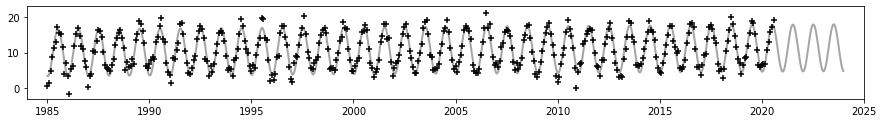

In [21]:
model = sklearn.linear_model.LinearRegression()
X = np.column_stack([np.sin(2*np.pi*t), np.cos(2*np.pi*t), t])
n = len(df)
model.fit(X, temp)

newt = np.linspace(1985, 2024, 1000)
newX = np.column_stack([np.sin(2*np.pi*newt), np.cos(2*np.pi*newt), newt])
newy = model.predict(newX)

fig,ax = plt.subplots(figsize=(15,1.7))
ax.set_xlim([1984,2025])
ax.set_ylim([-3,23])
ax.scatter(t, temp, color='black', marker='+', zorder=3)
ax.plot(newt, newy, color='0.3', zorder=2, lw=2, alpha=0.5)

plt.show()

In [ ]:
# Animation, showing the datasets that might have been.
# The theory behind this is covered in section 8 of the course.

import matplotlib.animation
from IPython.display import HTML

# Code to generate a synthetic dataset
pred = model.predict(X)
σ = np.linalg.norm(temp - pred) / np.sqrt(n)
def synthetic_temperatures(): return np.random.normal(loc=pred, scale=σ)

# First set up the figure, the axis, and the plot elements we want to animate
fig,ax = plt.subplots(figsize=(15,1.7))
ax.set_xlim([1984,2025])
ax.set_ylim([-3,23])
line, = ax.plot(newt, model.predict(newX), color='0.7')
points = ax.scatter([], [], s=15, alpha=0.7)
ax.scatter(t, temp, color='black', marker='+')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    points.set_offsets(np.zeros(shape=(0,2)))
    return [line,points]

# animation function.  This is called sequentially
def animate(i):
    newtemp = synthetic_temperatures() if i>0 else temp
    model.fit(X, newtemp)
    line.set_data(newt, model.predict(newX))
    if i > 0:
        points.set_offsets(np.column_stack([t,newtemp]))
    return [line,points]

anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=20, blit=True)
HTML(anim.to_jshtml())

# Appendix: retrieving the dataset

In [12]:
import numpy as np
import pandas
import requests, requests_cache
import urllib
import io, re
#import json, re
import numbers
requests_cache.install_cache(backend='memory')
BASE_URL = 'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/'

In [13]:
# Fetch a list of all measurement stations
station_url = urllib.parse.urljoin(BASE_URL, 'historic/historic.json')
stations = requests.get(station_url).json()
stations = [stations[status][k]['url'] for status in ['open','closed'] for k in stations[status]]

In [14]:
# Fetch historical data from each station
def parse_station_data(txt, i=None):
    ls = txt.splitlines()
    g = (i for i,l in enumerate(ls) if ' '.join(l.split()).startswith('yyyy mm tmax tmin'))
    header_line = next(g)
    d = '\n'.join([ls[header_line]+' status X1 X2 X3 X4 X5 X6'] + ls[(header_line+2):])
    df = pandas.read_csv(io.StringIO(d), delim_whitespace=True)
    df['station'] = [ls[0]] * len(df)
    s = ls[1] + ' ' + ls[2]
    m = re.search(r'Lat ([-\d.]+) Lon ([-\d.]+),? ([-\d.]+)\s?m.* amsl', s)
    assert m is not None, f"Can't read details for {i}: {s}"
    df['lat'] = [m.group(1)] * len(df)
    df['lng'] = [m.group(2)] * len(df)
    df['height'] = [m.group(3)] * len(df)
    return df
df = [requests.get(urllib.parse.urljoin(BASE_URL, 'stationdata/'+station_url)).content.decode('utf8') 
      for station_url in stations]
df = [parse_station_data(txt,i) for i,txt in enumerate(df)]

# Concatenate all the station together
df = pandas.concat(df, ignore_index=True)
# Sometimes there are comment rows, and df.yyy is string
# Sometimes there are no comment rows, and df.yyy is int
# This code removes any comment rows, safely in either case
df = df.loc[df.yyyy.astype(str) != 'Site']

# Delete some dummy columns (which were only there for rows with comments)
for i in range(1,7): del df[f'X{i}']

# Normalize some long-winded station names
for old,new in [('Heathrow (London Airport)','Heathrow'), 
                ('Lowestoft / Lowestoft Monckton Ave from Sept 2007','Lowestoft'),
                ('Whitby Coastguard / Whitby(from 2000 and $sunshine)','Whitby'),
                ('Nairn   there is a site change in 1998','Nairn'),
                ('Cambridge NIAB','Cambridge')]:
    df['station'] = np.where(df['station']==old, new, df['station'])
    
# Tidy the numerical columns, to only have numbers or NaN
def clean_num(x):
    if isinstance(x, numbers.Number):
        return x
    elif x == '---':
        return np.nan
    else:
        return float(re.match(r'([-\d.]+)', x).group(1))
df['tmin'] = np.array([clean_num(x) for x in df['tmin']])
df['tmax'] = np.array([clean_num(x) for x in df['tmax']])
df['yyyy'] = np.array([clean_num(x) for x in df['yyyy']])
df['mm'] = np.array([clean_num(x) for x in df['mm']])

In [ ]:
df.to_csv('climate.csv', index=False)